In [ ]:
!pip install torch
!pip install pandas
!pip install datasets
!pip install transformers
!pip install scikit-learn
!pip install peft
!pip install codecarbon
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [ ]:
import torch
import os
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import DatasetDict
from peft import get_peft_model, LoraConfig, TaskType
from transformers import TrainerCallback
import time
import matplotlib.pyplot as plt
from codecarbon import EmissionsTracker

In [ ]:
!wget https://perso.univ-lemans.fr/~ndugue/ohsumed-all.zip
!unzip ohsumed-all.zip

In [ ]:
ohsumed_dir = "ohsumed-all"

In [ ]:
labels = []
ids = []
paths = []
fichiers = []

for category in os.listdir(ohsumed_dir):
    cat_dir = os.path.join(ohsumed_dir, category)
    for fichier in os.listdir(cat_dir):
         if ".ipynb" not in fichier:
            fichier_path = os.path.join(cat_dir, fichier)
            labels.append(category)
            paths.append(fichier_path)
            ids.append(fichier)
            with open(fichier_path) as c_file:
                fichiers.append(c_file.read())

from datasets import Features, Value, ClassLabel, Dataset
features = Features(
{'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=23, id=None, names=list(set(labels))),
 'id': Value(dtype='string', id=None),
 'path': Value(dtype='string', id=None),
})

dico_data = {"text" : fichiers, "label" : labels, "id": ids, "path": paths}
ds = Dataset.from_dict(dico_data, features=features)
ds[0]

ds_split = ds.train_test_split(test_size=0.2, stratify_by_column="label")
ds_split
train_for_ft = ds_split["train"]
test_for_ft = ds_split["test"]

In [ ]:

# Préparer le tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

def tokenize_and_chunk(doc):
    return tokenizer(doc["text"], truncation = True, max_length=256, padding="max_length")

tokenized_train_for_ft = train_for_ft.map(tokenize_and_chunk,batched=True, num_proc=8)
tokenized_test_for_ft = test_for_ft.map(tokenize_and_chunk,batched=True, num_proc=8)

# Charger le modèle pré-entraîné sans fine-tuning
base_model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-base", num_labels=23)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map (num_proc=8):   0%|          | 0/45587 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/11397 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Récupérer les noms des classes directement à partir du dataset
class_names = tokenized_train_for_ft.features['label'].names

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None, zero_division=1)

    # Calcul des métriques globales (moyenne des classes)
    precision_global = precision.mean()
    recall_global = recall.mean()
    f1_macro = f1.mean()  # Ajout du F1-score macro

    metrics = {
        "accuracy": accuracy,
        "precision_global": precision_global,
        "recall_global": recall_global,
        "f1_macro": f1_macro
    }

    # Ajouter les métriques par classe avec les noms explicites
    for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
        metrics[f"precision_{class_names[i]}"] = p
        metrics[f"recall_{class_names[i]}"] = r
        metrics[f"f1_{class_names[i]}"] = f

    return metrics

# Configurer LoRA
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,  # Rang de la décomposition
    lora_alpha=16,  # Facteur d'adaptation
    lora_dropout=0.1,
    target_modules=["query_proj", "key_proj", "value_proj", "dense"]
)

# Appliquer LoRA au modèle
model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()

# Configurer l'entraînement avec fine-tuning LoRA
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none",
    overwrite_output_dir=True,
    disable_tqdm=False
)

# Initialisation du Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_for_ft,  # Dataset d'entraînement
    eval_dataset=tokenized_test_for_ft,  # Dataset de test
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

tracker = EmissionsTracker()
tracker.start()

train_result = trainer.train()

emissions = tracker.stop()


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


trainable params: 1,357,079 || all params: 185,796,910 || trainable%: 0.7304


<ipython-input-7-abcd9baf716c>:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
[codecarbon INFO @ 19:10:58] [setup] RAM Tracking...
[codecarbon INFO @ 19:10:58] [setup] CPU Tracking...
[codecarbon WARNING @ 19:10:58] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon WARNING @ 19:11:00] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 19:11:00] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecar

Epoch,Training Loss,Validation Loss,Accuracy,Precision Global,Recall Global,F1 Macro,Precision C15,Recall C15,F1 C15,Precision C23,Recall C23,F1 C23,Precision C07,Recall C07,F1 C07,Precision C02,Recall C02,F1 C02,Precision C19,Recall C19,F1 C19,Precision C13,Recall C13,F1 C13,Precision C03,Recall C03,F1 C03,Precision C06,Recall C06,F1 C06,Precision C08,Recall C08,F1 C08,Precision C01,Recall C01,F1 C01,Precision C12,Recall C12,F1 C12,Precision C14,Recall C14,F1 C14,Precision C09,Recall C09,F1 C09,Precision C05,Recall C05,F1 C05,Precision C18,Recall C18,F1 C18,Precision C22,Recall C22,F1 C22,Precision C16,Recall C16,F1 C16,Precision C21,Recall C21,F1 C21,Precision C04,Recall C04,F1 C04,Precision C17,Recall C17,F1 C17,Precision C10,Recall C10,F1 C10,Precision C11,Recall C11,F1 C11,Precision C20,Recall C20,F1 C20
1,1.841600,1.950236,0.405633,0.447169,0.293374,0.259889,0.000000,0.000000,0.000000,0.240766,0.091571,0.132680,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.005780,0.011429,0.338235,0.566154,0.423475,1.000000,0.000000,0.000000,0.401907,0.493311,0.442943,0.378893,0.422780,0.399635,0.298682,0.401575,0.342569,0.411765,0.416667,0.414201,0.538462,0.757377,0.629428,1.000000,0.000000,0.000000,0.293103,0.151786,0.200000,0.403614,0.523438,0.455782,1.000000,0.000000,0.000000,0.125000,0.004608,0.008889,0.580336,0.412266,0.482072,0.464319,0.791469,0.585280,0.229167,0.170279,0.195382,0.418530,0.510390,0.459918,0.348739,0.415000,0.378995,0.313372,0.613162,0.414767


[codecarbon INFO @ 19:11:15] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 19:11:15] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:11:15] Energy consumed for all GPUs : 0.000235 kWh. Total GPU Power : 56.29266203456956 W
[codecarbon INFO @ 19:11:15] 0.000432 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:11:30] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 19:11:30] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:11:30] Energy consumed for all GPUs : 0.000520 kWh. Total GPU Power : 68.60647478969882 W
[codecarbon INFO @ 19:11:30] 0.000914 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:11:45] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 19:11:45] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codeca

In [ ]:
import torch
import pandas as pd
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from codecarbon import EmissionsTracker

# Charger le modèle de base
base_model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-base", num_labels=23)

freeze_mode = "last_layers"
if freeze_mode == "head":
    for param in base_model.deberta.parameters():
        param.requires_grad = False  # Gèle tout sauf la tête

elif freeze_mode == "last_layers":
    for param in base_model.deberta.parameters():
        param.requires_grad = False  # Gèle tout
    for layer in base_model.deberta.encoder.layer[-2:]:  # Dégeler les 2 dernières couches
        for param in layer.parameters():
            param.requires_grad = True

elif freeze_mode == "embeddings":
    for param in base_model.deberta.embeddings.parameters():
        param.requires_grad = False  # Gèle uniquement les embeddings

elif freeze_mode == "none":
    pass  # Fine-tune complet

# Vérifier les paramètres entraînables
for name, param in base_model.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")

# Fonction de calcul des métriques
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None, zero_division=1)

    return {
        "accuracy": accuracy,
        "precision_global": precision.mean(),
        "recall_global": recall.mean(),
        "f1_macro": f1.mean()
    }

# Arguments d'entraînement
training_args = TrainingArguments(
    output_dir="./results_withoutlora",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,  # Augmenté pour mieux comparer
    weight_decay=0.01,
    report_to="none",
    overwrite_output_dir=True,
    disable_tqdm=False
)

# Initialisation du Trainer
trainer = Trainer(
    model=base_model,
    args=training_args,
    train_dataset=tokenized_train_for_ft,  # Dataset d'entraînement
    eval_dataset=tokenized_test_for_ft,  # Dataset de test
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
# Suivi de l'empreinte carbone
tracker = EmissionsTracker()
tracker.start()


train_result = trainer.train()

# Fin du suivi carbone
emissions = tracker.stop()


In [ ]:
def plot_loss(trainer):
    """
    Affiche la courbe de la loss en utilisant les steps des logs.
    """
    history = pd.DataFrame(trainer.state.log_history)

    if not history.empty and 'loss' in history:
        plt.figure(figsize=(12, 5))

        loss_history = history.dropna(subset=['loss'])

        plt.plot(loss_history['step'], loss_history['loss'], label="Loss d'entraînement",
                 marker='o', linestyle='-', color='blue', markersize=3)

        plt.xlabel("Steps")
        plt.ylabel("Loss")
        plt.title("Évolution de la Loss")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig("./results/learning_curves_lora.png")
        plt.show()

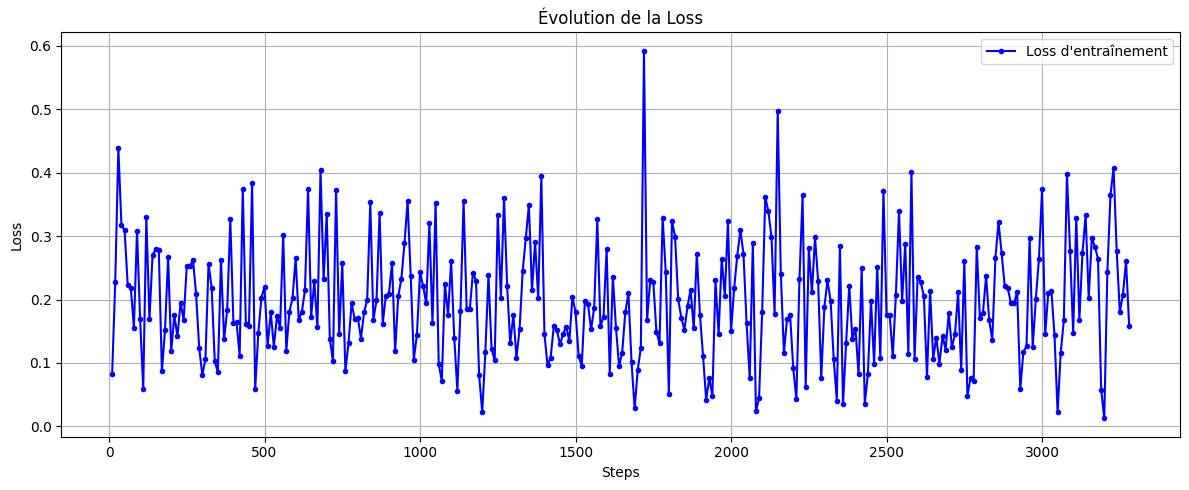

In [ ]:
plot_loss(trainer)

In [ ]:
def generate_metrics_report(trainer, final_metrics, training_args, lora_config, emissions):
    """
    Génère un rapport compact avec les métriques clés.
    """
    def safe_format(value):
        return f"{value:.4f}" if isinstance(value, (int, float)) else str(value)

    history = pd.DataFrame(trainer.state.log_history)

    # Calcul du temps moyen par époque
    if 'train_runtime' in history.columns and 'epoch' in history.columns:
        epoch_times = history[history['epoch'].notna()].groupby('epoch')['train_runtime'].mean()
        mean_epoch_time = epoch_times.mean() if not epoch_times.empty else "N/A"
        epochs_table = epoch_times.to_frame().to_markdown()
    else:
        mean_epoch_time = "N/A"
        epochs_table = "Données non disponibles"

    report = f"""
# Rapport d'entraînement et d'évaluation

## **Résultats**
- **Accuracy** : {safe_format(final_metrics.get('eval_accuracy', 'N/A'))}
- **F1-score** : {safe_format(final_metrics.get('eval_f1_macro', 'N/A'))}
- **Precision globale** : {safe_format(final_metrics.get('eval_precision_global', 'N/A'))}
- **Recall global** : {safe_format(final_metrics.get('eval_recall_global', 'N/A'))}
- **Loss finale** : {safe_format(final_metrics.get('eval_loss', 'N/A'))}

## **Hyperparamètres principaux**
- **Epochs** : {training_args.num_train_epochs}
- **Batch (train/eval)** : {training_args.per_device_train_batch_size} / {training_args.per_device_eval_batch_size}
- **Weight Decay** : {training_args.weight_decay}
- **LoRA Config** : r={lora_config.r}, alpha={lora_config.lora_alpha}, dropout={lora_config.lora_dropout}

## **Temps d'entraînement**
- **Temps moyen par époque** : {safe_format(mean_epoch_time)} sec

## **Empreinte carbone**
- **CO₂ estimé** : {safe_format(emissions)} kg

## **Courbes d'apprentissage**
`./results/learning_curves_lora.png`
"""
    with open("./results/training_report_lora.txt", "w") as f:
        f.write(report)
    print(report)


In [ ]:
import pandas as pd

def generate_metrics_report(trainer, final_metrics, training_args, emissions):
    """
    Génère un rapport compact avec les métriques clés (sans LoRA).
    """
    def safe_format(value):
        return f"{value:.4f}" if isinstance(value, (int, float)) else str(value)

    history = pd.DataFrame(trainer.state.log_history)

    # Calcul du temps moyen par époque
    if 'train_runtime' in history.columns and 'epoch' in history.columns:
        epoch_times = history[history['epoch'].notna()].groupby('epoch')['train_runtime'].mean()
        mean_epoch_time = epoch_times.mean() if not epoch_times.empty else "N/A"
        epochs_table = epoch_times.to_frame().to_markdown()
    else:
        mean_epoch_time = "N/A"
        epochs_table = " Données non disponibles"

    report = f"""
# Rapport d'entraînement et d'évaluation

## **Résultats**
- **Accuracy** : {safe_format(final_metrics.get('eval_accuracy', 'N/A'))}
- **F1-score** : {safe_format(final_metrics.get('eval_f1_macro', 'N/A'))}
- **Precision globale** : {safe_format(final_metrics.get('eval_precision_global', 'N/A'))}
- **Recall global** : {safe_format(final_metrics.get('eval_recall_global', 'N/A'))}
- **Loss finale** : {safe_format(final_metrics.get('eval_loss', 'N/A'))}

## **Hyperparamètres principaux**
- **Epochs** : {training_args.num_train_epochs}
- **Batch (train/eval)** : {training_args.per_device_train_batch_size} / {training_args.per_device_eval_batch_size}
- **Weight Decay** : {training_args.weight_decay}

## ⏱ **Temps d'entraînement**
- **Temps moyen par époque** : {safe_format(mean_epoch_time)} sec

## **Empreinte carbone**
- **CO₂ estimé** : {safe_format(emissions)} kg

## **Courbes d'apprentissage**
 `./results/learning_curves.png`
"""
    with open("./results/training_report.txt", "w") as f:
        f.write(report)
    print(report)


In [ ]:
final_metrics = trainer.evaluate()
generate_metrics_report(trainer, final_metrics, training_args, lora_config, emissions)
print(final_metrics)

In [ ]:
!zip -r mon_dossier.zip ./

In [ ]:
from google.colab import files
files.download("mon_dossier.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>